# Importing Libraries

source: https://www.kaggle.com/code/sharanharsoor/skin-cancer-detection#Model-3-:-Model-with-Class-balance-data.

python ver: 3.10.11

pip ver: 24.2

To install required libraries, use the following command:

```bash
pip install -r requirements.txt

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if gpus:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth set for GPU:", gpus[0])
    except Exception as ex:
        print("Error while setting memory growth:", ex)
else:
    print("No GPUs found.")


[]
No GPUs found.


# Reading data

In [9]:
data_dir_train = pathlib.Path("data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare dataset

In [11]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


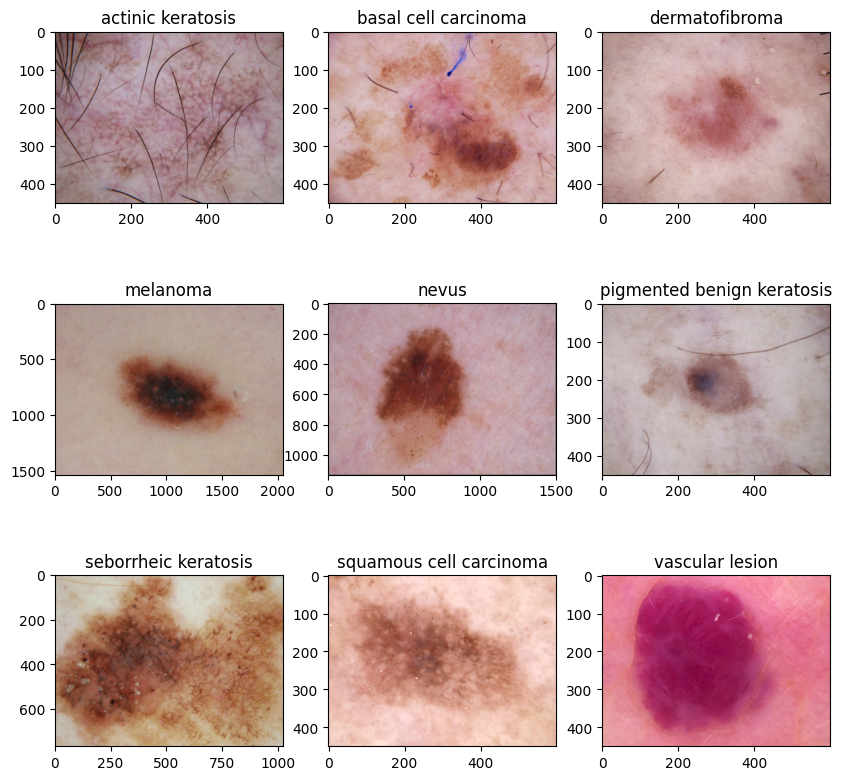

In [16]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [17]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1: Standard model

In [19]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [20]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 45s 758ms/step - loss: 2.0392 - accuracy: 0.2070 - val_loss: 1.9633 - val_accuracy: 0.2796
Epoch 2/25
56/56 [==============================] - 42s 747ms/step - loss: 1.8090 - accuracy: 0.3242 - val_loss: 1.6483 - val_accuracy: 0.4430
Epoch 3/25
56/56 [==============================] - 42s 751ms/step - loss: 1.6529 - accuracy: 0.4102 - val_loss: 1.6211 - val_accuracy: 0.3848
Epoch 4/25
56/56 [==============================] - 41s 738ms/step - loss: 1.6706 - accuracy: 0.3789 - val_loss: 1.5731 - val_accuracy: 0.4586
Epoch 5/25
56/56 [==============================] - 41s 736ms/step - loss: 1.4681 - accuracy: 0.4855 - val_loss: 1.5363 - val_accuracy: 0.4698
Epoch 6/25
56/56 [==============================] - 41s 739ms/step - loss: 1.5441 - accuracy: 0.4509 - val_loss: 1.4911 - val_accuracy: 0.4966
Epoch 7/25
56/56 [==============================] - 42s 745ms/step - loss: 1.4693 - accuracy: 0.4838 - val_loss: 1.5867 - val_accuracy: 0.4609

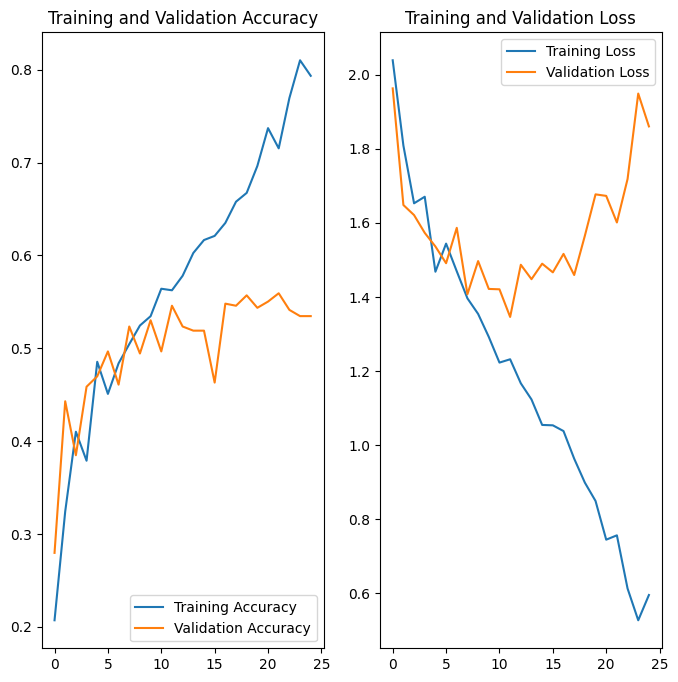

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :
The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%.

The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features.

data imbalance might be causing the bais to the model.

# Model 2 : Data Augumentation with drop out layer

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

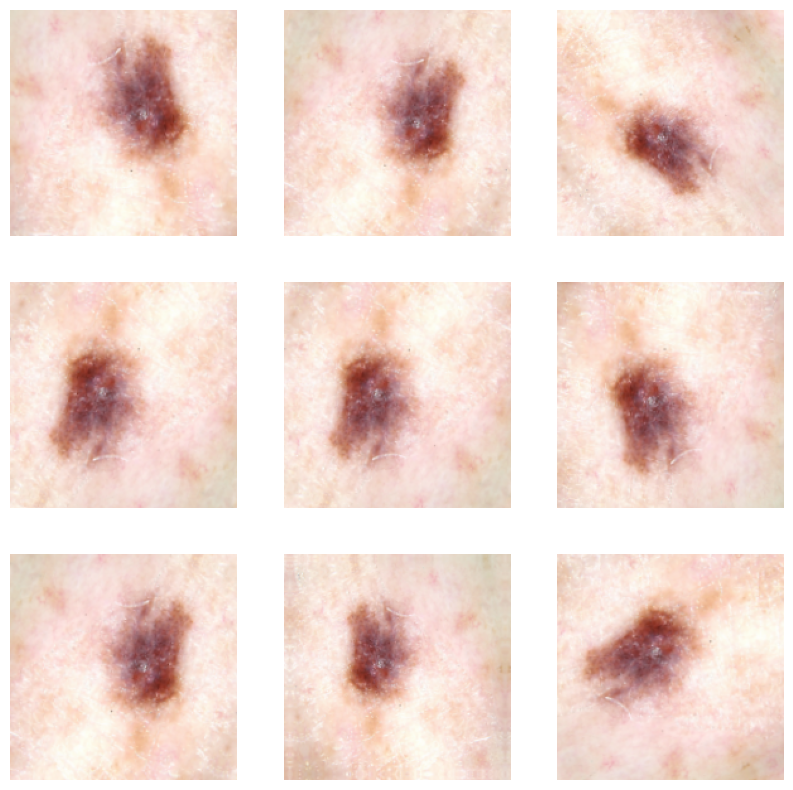

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [28]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 45s 789ms/step - loss: 2.0799 - accuracy: 0.2042 - val_loss: 1.9921 - val_accuracy: 0.2438
Epoch 2/25
56/56 [==============================] - 44s 788ms/step - loss: 1.9318 - accuracy: 0.2718 - val_loss: 1.8927 - val_accuracy: 0.3087
Epoch 3/25
56/56 [==============================] - 43s 777ms/step - loss: 1.8396 - accuracy: 0.3092 - val_loss: 1.7454 - val_accuracy: 0.3870
Epoch 4/25
56/56 [==============================] - 44s 782ms/step - loss: 1.6909 - accuracy: 0.3878 - val_loss: 1.6534 - val_accuracy: 0.3937
Epoch 5/25
56/56 [==============================] - 44s 780ms/step - loss: 1.6183 - accuracy: 0.4157 - val_loss: 1.6022 - val_accuracy: 0.4385
Epoch 6/25
56/56 [==============================] - 44s 790ms/step - loss: 1.5521 - accuracy: 0.4369 - val_loss: 1.4953 - val_accuracy: 0.4676
Epoch 7/25
56/56 [==============================] - 44s 791ms/step - loss: 1.5067 - accuracy: 0.4542 - val_loss: 1.4946 - val_accuracy: 0.4855

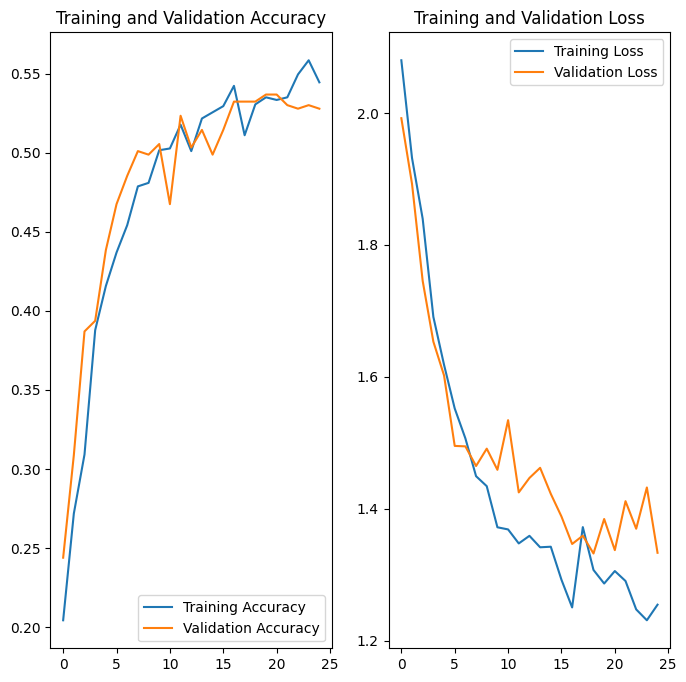

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings
With data agumenatation and drop layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%.

The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model.

Considering above 2 points, there is still a scope of lot of improvement of the model.

# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

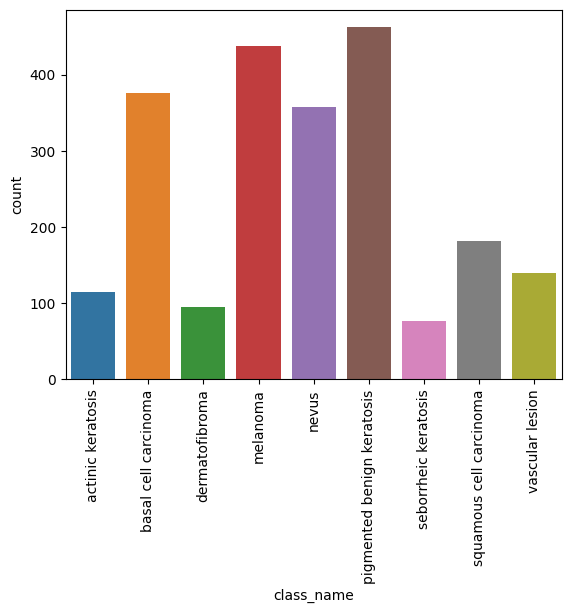

In [31]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Findings
Data is hevily imbalance and hence due to that results and predictions will be baised.

# Augmentor : Class balance

Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

!pip install Augmentor

In [46]:
path_to_training_dataset = 'data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='Augmentor_Train/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\Augmentor_Train/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F987C019F0>: 100%|██████████| 1000/1000 [00:02<00:00, 429.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\Augmentor_Train/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F986470FD0>: 100%|██████████| 1000/1000 [00:02<00:00, 411.61 Samples/s]                 


Initialised with 95 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\Augmentor_Train/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F9817EE2F0>: 100%|██████████| 1000/1000 [00:02<00:00, 406.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\Augmentor_Train/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1F98128F460>: 100%|██████████| 1000/1000 [00:12<00:00, 78.57 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\Augmentor_Train/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1F987C64940>: 100%|██████████| 1000/1000 [00:11<00:00, 85.01 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\Augmentor_Train/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F9F1EA3190>: 100%|██████████| 1000/1000 [00:02<00:00, 359.72 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\Augmentor_Train/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1F9818F3C70>: 100%|██████████| 1000/1000 [00:06<00:00, 154.96 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\Augmentor_Train/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F9F1EA1E70>: 100%|██████████| 1000/1000 [00:02<00:00, 334.06 Samples/s]                 


Initialised with 139 image(s) found.
Output directory set to data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\Augmentor_Train/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F981A73460>: 100%|██████████| 1000/1000 [00:02<00:00, 387.78 Samples/s]                  


In [54]:
output_dir = pathlib.Path('data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
image_count_train = len(list(output_dir.glob('*/Augmentor_Train/*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

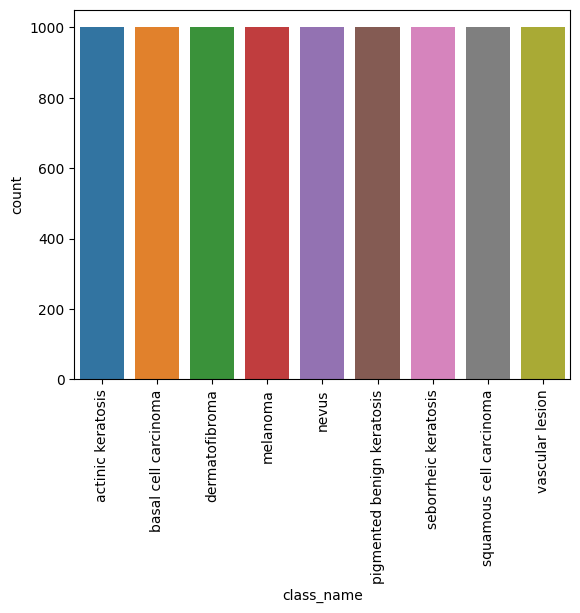

In [56]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'*/Augmentor_Train/*/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'*/Augmentor_Train/*/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3 : Model with Class balance data

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [59]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [60]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [61]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
281/281 [==============================] - 215s 762ms/step - loss: 2.1672 - accuracy: 0.1480 - val_loss: 1.8845 - val_accuracy: 0.2715
Epoch 2/25
281/281 [==============================] - 215s 763ms/step - loss: 1.7190 - accuracy: 0.3121 - val_loss: 1.5032 - val_accuracy: 0.4183
Epoch 3/25
281/281 [==============================] - 215s 765ms/step - loss: 1.4225 - accuracy: 0.4384 - val_loss: 1.2556 - val_accuracy: 0.5065
Epoch 4/25
281/281 [==============================] - 215s 763ms/step - loss: 1.2393 - accuracy: 0.5171 - val_loss: 1.1494 - val_accuracy: 0.5518
Epoch 5/25
281/281 [==============================] - 214s 759ms/step - loss: 1.0436 - accuracy: 0.5950 - val_loss: 0.8601 - val_accuracy: 0.6814
Epoch 6/25
281/281 [==============================] - 214s 762ms/step - loss: 0.8748 - accuracy: 0.6614 - val_loss: 0.7415 - val_accuracy: 0.7178
Epoch 7/25
281/281 [==============================] - 214s 761ms/step - loss: 0.7155 - accuracy: 0.7282 - val_loss: 0.6425 -

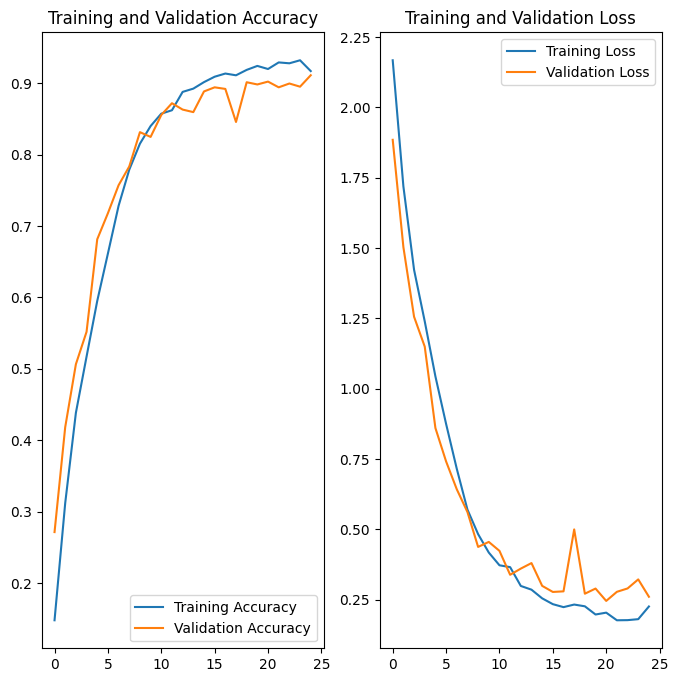

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :
After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the mdoel to 90%. This addressed the low accurty problem.

overfitting probelm is adressed and now difference between train and val set is nearly 4-5% diff.

with these results it's conclusive that current module with rebalanced data is the best module.

# Evaluation

In [64]:
#Create a file to save models
top_model_weights_path = 'cnn_fc_model.h5'
model.save_weights(top_model_weights_path)

In [73]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

4/4 [==============================] - 2s 90ms/step - loss: 5.4773 - accuracy: 0.3774


In [67]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

[INFO] accuracy: 37.74%
[INFO] Loss: 5.477249622344971
